In [1]:
import sys
import os
import tensorflow as tf

from sklearn.model_selection import train_test_split

In [2]:
sys.path.append(os.path.abspath('..'))
from src.generator import BraTSGenerator
from src.architectures.unet_3d import build_unet_3d
from src.training.losses import dice_loss, dice_coef

In [3]:
# Configuration
DATA_DIR = '../data/02_processed/train'
BATCH_SIZE = 2
EPOCHS = 100
LR = 1e-4
IMG_SIZE = (128, 128, 128)

EXP_NUMBER = 1

In [4]:
# Create model directory
model_dir = f"../models/model_{EXP_NUMBER}"
os.makedirs(model_dir, exist_ok=True)

In [5]:
# Split dataset
patient_ids = os.listdir(DATA_DIR)
train_ids, temp_ids = train_test_split(patient_ids, test_size=0.3, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

# --- Summary ---
print(f"Total patients: {len(patient_ids)}")
print("-" * 30)
print(f"TRAIN (70%):        {len(train_ids)} patients")
print(f"VALIDATION (15%):    {len(val_ids)} patients")
print(f"TEST (15%):          {len(test_ids)} patients")

Total patients: 369
------------------------------
TRAIN (70%):        258 patients
VALIDATION (15%):    55 patients
TEST (15%):          56 patients


In [12]:
# Create data generators
train_gen = BraTSGenerator(train_ids, DATA_DIR, batch_size=BATCH_SIZE, img_size=IMG_SIZE)
val_gen = BraTSGenerator(val_ids, DATA_DIR, batch_size=BATCH_SIZE, img_size=IMG_SIZE)

In [7]:
# Build and compile model
model = build_unet_3d(input_shape=(*IMG_SIZE, 4), start_filters=32)
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
model.compile(optimizer=optimizer, loss=dice_loss, metrics=[dice_coef, 'accuracy'])
model.summary()

I0000 00:00:1770412118.607859  316068 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9498 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "U-Net_3D"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 4)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 128, 128,  │      3,488 │ input_layer[0][0] │
│                     │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv3d[0][0]      │
│ (BatchNormalizatio… │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 128, 128,  │     27,680 │ activation[0][0]  │
│                     │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv3d_1[0][0]    │
│ (BatchNormalizatio… │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling3D)      │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 64, 64,    │     55,360 │ max_pooling3d[0]… │
│                     │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv3d_2[0][0]    │
│ (BatchNormalizatio… │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 64, 64,    │    110,656 │ activation_2[0][… │
│                     │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv3d_3[0][0]    │
│ (BatchNormalizatio… │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 32, 32,    │          0 │ activation_3[0][… │
│ (MaxPooling3D)      │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 32, 32,    │    221,312 │ max_pooling3d_1[… │
│                     │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv3d_4[0][0]  

 Total params: 22,589,796 (86.17 MB)

 Trainable params: 22,583,908 (86.15 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [8]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        f"{model_dir}/best_model.keras",
        verbose=1,
        save_best_only=True,
        monitor='val_dice_coef',
        mode='max'
    ),

    tf.keras.callbacks.ReduceLROnPlateau(
		monitor='val_loss',
		factor=0.5,
		patience=5,
		verbose=1
	),

	tf.keras.callbacks.EarlyStopping(
        monitor='val_dice_coef',
        patience=15,
        mode='max',
        verbose=1,
        restore_best_weights=True
    ),

    tf.keras.callbacks.CSVLogger(
        f'{model_dir}/training_log.csv',
        separator=',',
        append=True
    )
]

In [ ]:
# Train model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
	verbose=1,
)

In [ ]:
model.save(f"{model_dir}/final_model.keras")

In [ ]:
# Plot training history
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2, color='red')
axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2, linestyle='--', color='darkred')
axes[0].set_title('Loss Function', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['dice_coef'], label='Train Dice', linewidth=2, color='green')
axes[1].plot(history.history['val_dice_coef'], label='Val Dice', linewidth=2, linestyle='--', color='darkgreen')
axes[1].set_title('Dice Coefficient', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Dice Score')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

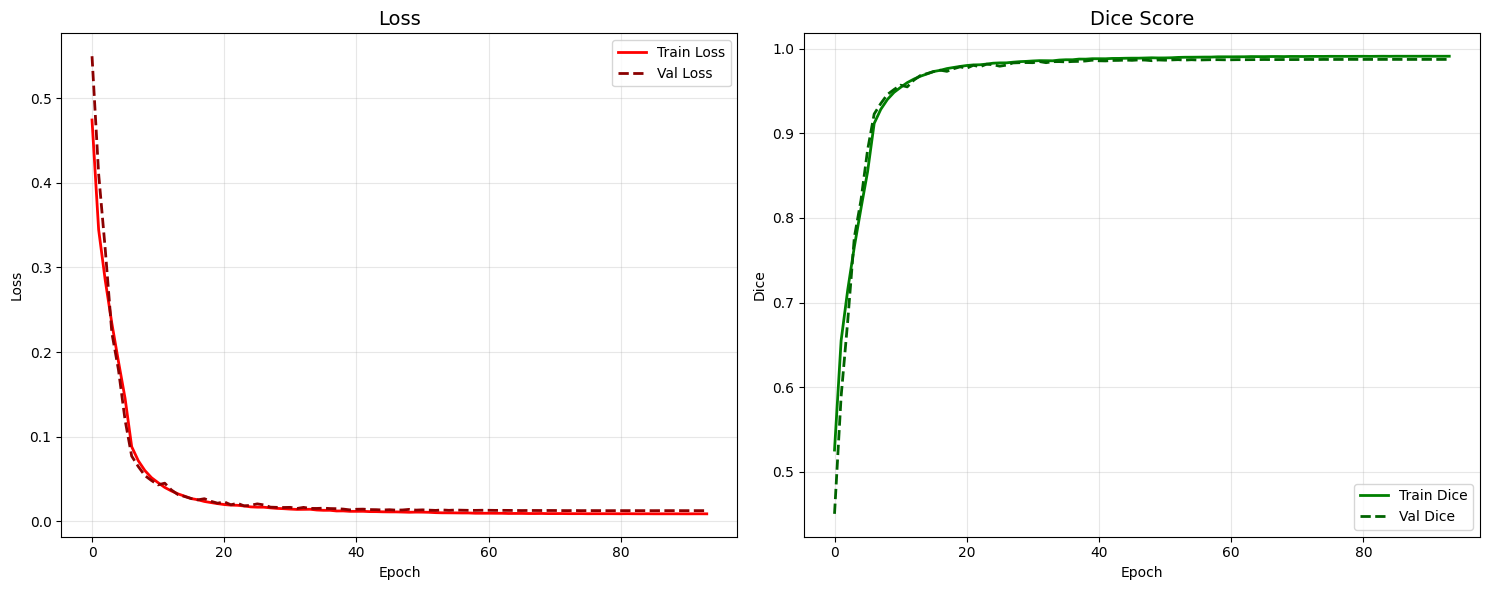

In [9]:
# Plot training history from CSV log if necessary
import pandas as pd

log_path = f'{model_dir}/training_log.csv'
history_df = pd.read_csv(log_path)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].plot(history_df['epoch'], history_df['loss'], label='Train Loss', linewidth=2, color='red')
if 'val_loss' in history_df.columns:
    axes[0].plot(history_df['epoch'], history_df['val_loss'], label='Val Loss', linewidth=2, linestyle='--', color='darkred')
axes[0].set_title('Loss', fontsize=14)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_df['epoch'], history_df['dice_coef'], label='Train Dice', linewidth=2, color='green')
axes[1].plot(history_df['epoch'], history_df['val_dice_coef'], label='Val Dice', linewidth=2, linestyle='--', color='darkgreen')
axes[1].set_title('Dice Score', fontsize=14)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Dice')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
# Load model for test
import numpy as np
import nibabel as nib
from src.preprocessing import _normalize

import matplotlib.pyplot as plt

MODEL_PATH = f'../models/model_{EXP_NUMBER}/best_model.keras'
model = tf.keras.models.load_model(
    MODEL_PATH,
    custom_objects={'dice_loss': dice_loss, 'dice_coef': dice_coef}
)

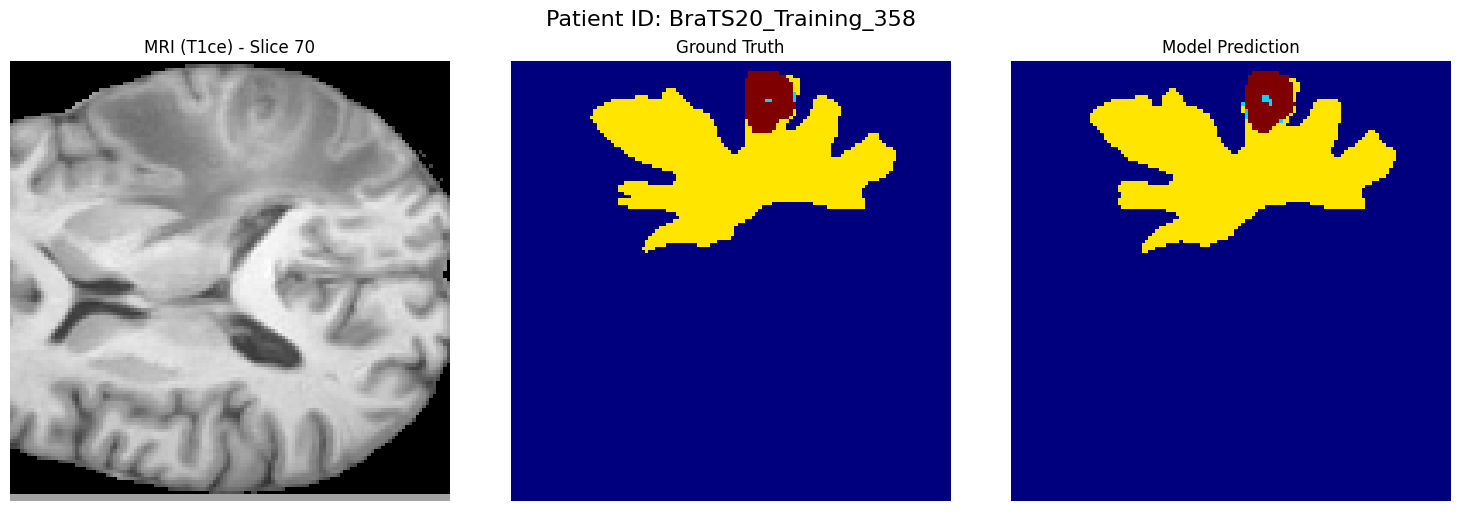

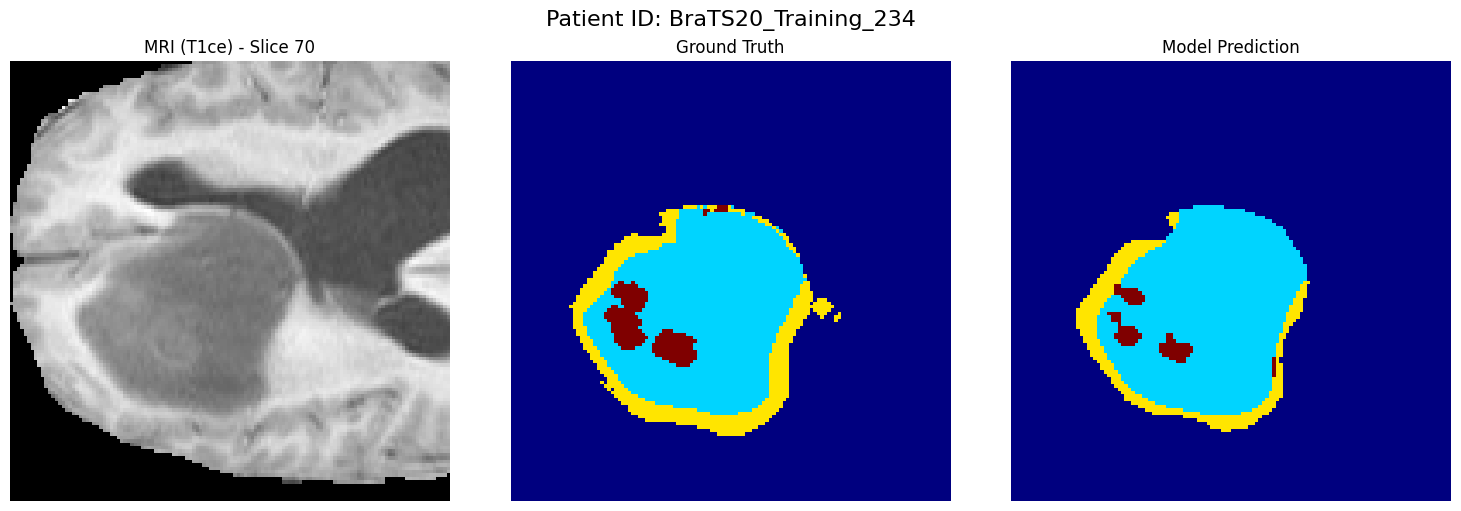

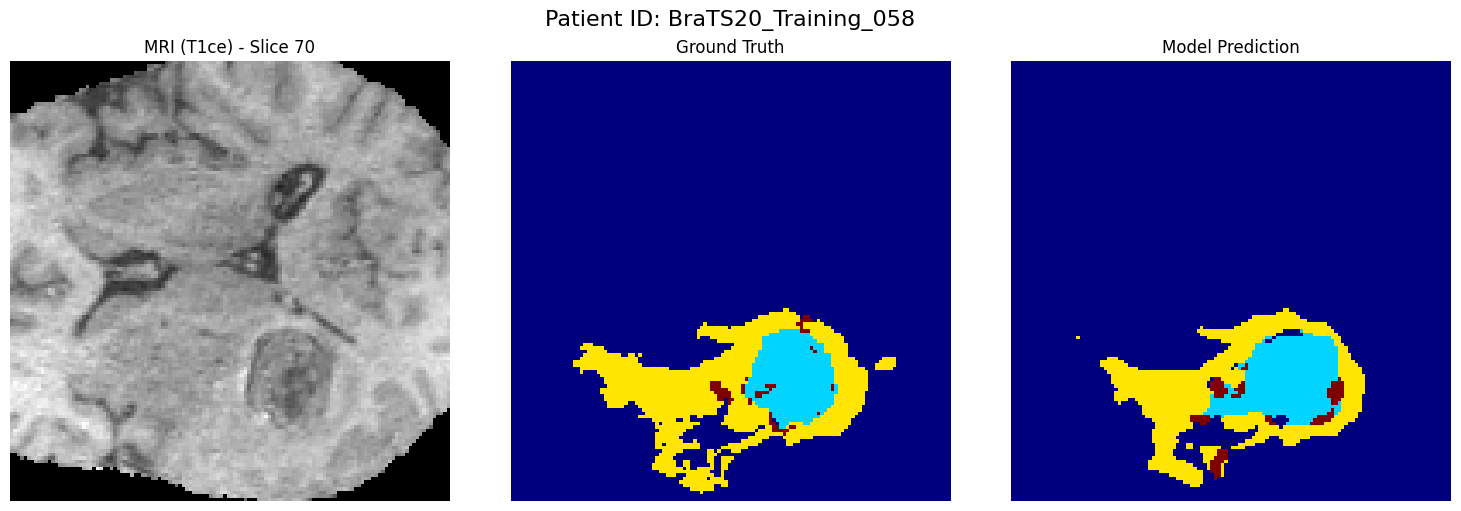

In [17]:
def visualize_prediction(patient_id, slice_idx=75):
    """Visualize model prediction vs ground truth for a given patient."""
    path = os.path.join(DATA_DIR, patient_id)

    try:
        vol = nib.load(os.path.join(path, 'volume.nii')).get_fdata()
        mask = nib.load(os.path.join(path, 'mask.nii')).get_fdata()
    except FileNotFoundError:
        print(f"Files not found for patient {patient_id}")
        return

    vol = _normalize(vol)
    X = np.expand_dims(vol, axis=0)

    pred_raw = model.predict(X, verbose=0)
    pred_mask = np.argmax(pred_raw[0], axis=-1)

    if mask.ndim == 4:
        mask = np.argmax(mask, axis=-1)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
    fig.patch.set_facecolor('white')

    # 1. MRI Image (T1ce)
    ax[0].imshow(vol[:, :, slice_idx, 1], cmap='gray')
    ax[0].set_title(f"MRI (T1ce) - Slice {slice_idx}")
    ax[0].axis('off')
    
    # 2. Ground Truth (Ekspert)
    ax[1].imshow(mask[:, :, slice_idx], cmap='jet', vmin=0, vmax=3)
    ax[1].set_title("Ground Truth")
    ax[1].axis('off')
    
    # 3. Model Prediction (AI)
    ax[2].imshow(pred_mask[:, :, slice_idx], cmap='jet', vmin=0, vmax=3)
    ax[2].set_title("Model Prediction")
    ax[2].axis('off')

    plt.suptitle(f"Patient ID: {patient_id}", fontsize=16)
    plt.show()

# Visualize predictions on test set
for pid in test_ids[:3]:
    visualize_prediction(pid, slice_idx=70)